In [1]:
import os
import kagglehub

import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from typing import List, Tuple

/mnt/nfs/home/vujasino/jupyter_workspace/Audits/merlin/.pixi/envs/default/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Downloading data

In [2]:
path = kagglehub.dataset_download("uciml/adult-census-income")
out_path = "../data/adult-census-income"
%rm -r $out_path
%mv $path $out_path

100%|██████████| 450k/450k [00:00<00:00, 2.29MB/s]

Extracting files...


## Data Loading and Analysis

Excerpt from a reference paper "We use age, years of education, capital gain, capital loss, hours-per-week, etc., as continuous features, and education level, gender, etc., as categorical features."

In [3]:
data_path = os.path.join(out_path, "adult.csv")
adult_df = pd.read_csv(data_path)
adult_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
continuous_cols = ["age", "education.num", "capital.gain", "capital.loss", "hours.per.week"]
categorical_cols = ["education", "sex"]

### Data Analysis

#### NaN presence analysis

In [5]:
print("NaNs per continuous column:")
dict(zip(continuous_cols, adult_df[continuous_cols].isna().sum(axis=0)))

NaNs per continuous column:


{'age': 0,
 'education.num': 0,
 'capital.gain': 0,
 'capital.loss': 0,
 'hours.per.week': 0}

In [6]:
for col in categorical_cols:
    print(f"{col} values:", adult_df[col].unique())

education values: ['HS-grad' 'Some-college' '7th-8th' '10th' 'Doctorate' 'Prof-school'
 'Bachelors' 'Masters' '11th' 'Assoc-acdm' 'Assoc-voc' '1st-4th' '5th-6th'
 '12th' '9th' 'Preschool']
sex values: ['Female' 'Male']


#### Distributions

In [7]:
def get_approx_subplots_square(n: int) -> Tuple[int, int]:
    """
    Calculate the approximate number of rows and columns for subplots to form close to a square layout.

    Args:
        n (int): The total number of subplots.

    Returns:
        Tuple[int, int]: A tuple containing the number of rows and columns.
    """
    nrows = np.floor(np.sqrt(n)).astype(int)
    ncols = np.ceil(n / nrows).astype(int)
    return nrows, ncols

def square_subplots_prep(n: int, *args, **kwargs) -> Tuple[plt.Figure, np.ndarray]:
    """
    Prepare a square grid of subplots and return the figure and axes.

    This function creates a grid of subplots that is as close to square as possible,
    given the number of subplots `n`. It removes any unused subplots and flattens
    the axes array to return only the used subplots.

    Parameters:
    -----------
    n : int
        The number of subplots to create.
    *args : tuple
        Additional positional arguments to pass to `plt.subplots`.
    **kwargs : dict
        Additional keyword arguments to pass to `plt.subplots`.

    Returns:
    --------
    Tuple[plt.Figure, np.ndarray]
        A tuple containing the figure and an array of the used axes.
    """
    nrows, ncols = get_approx_subplots_square(n)
    fig, axs = plt.subplots(nrows, ncols, *args, **kwargs)
    # Remove unused subplots and flatten the axes array
    for ax in axs.reshape(-1)[n:]:
        fig.delaxes(ax)
    axs = axs.reshape(-1)[:n]
    return fig, axs

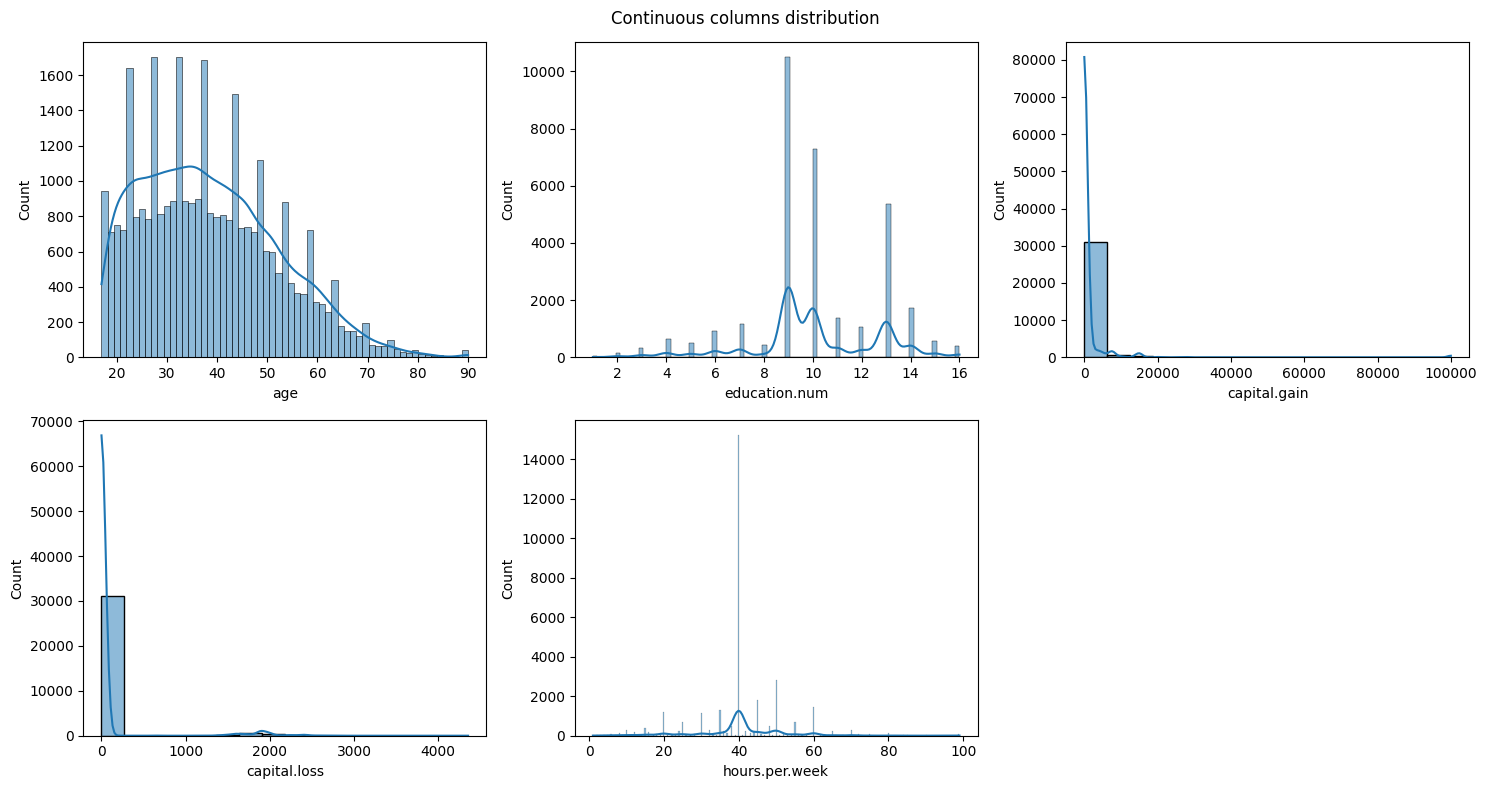

In [8]:
cols_to_plot = continuous_cols
fig, axs = square_subplots_prep(len(cols_to_plot), figsize=(15, 8))

for ax, col in zip(axs, cols_to_plot):
    sns.histplot(adult_df[col], kde=True, ax=ax)

fig.suptitle("Continuous columns distribution")
plt.tight_layout()
plt.show()

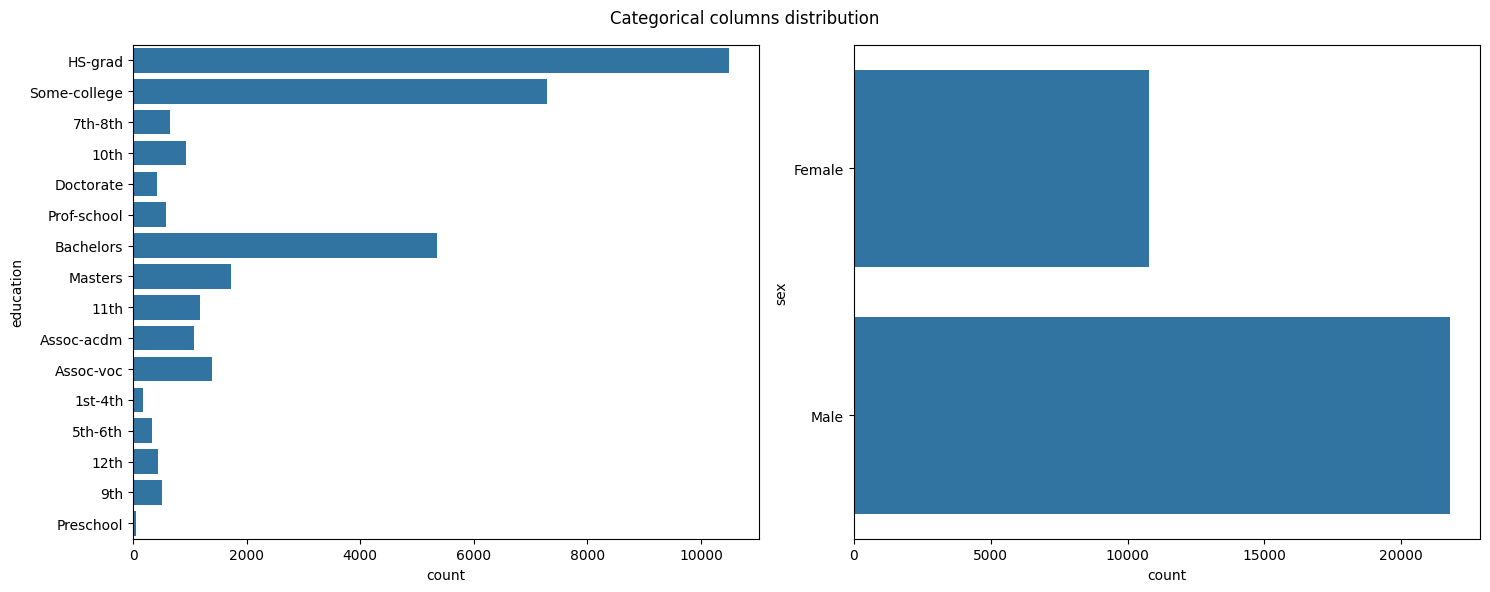

In [9]:
cols_to_plot = categorical_cols
fig, axs = square_subplots_prep(len(cols_to_plot), figsize=(15, 6))

for ax, col in zip(axs, cols_to_plot):
    sns.countplot(adult_df[col], ax=ax)

fig.suptitle("Categorical columns distribution")
plt.tight_layout()
plt.show()

### Processing Data

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
adult_df_X = adult_df[continuous_cols + categorical_cols]
adult_df_y = adult_df["income"]

In [12]:
fairly_normal_continuous_cols = ["age", "education.num", "hours.per.week"]

def create_pipeline(train_X_df: pd.DataFrame, train_y_series: pd.Series) -> dict:
    global continuous_cols, categorical_cols, fairly_normal_continuous_cols
    categorical_encoder = OneHotEncoder(drop="if_binary", sparse_output=False).fit(train_X_df[categorical_cols])
    y_encoder = OneHotEncoder(drop="if_binary", sparse_output=False).fit(train_y_series.to_frame())
    normal_dist_scaler = StandardScaler().fit(train_X_df[continuous_cols])
    return {
        "categorical_encoder": categorical_encoder,
        "y_encoder": y_encoder,
        "normal_dist_scaler": normal_dist_scaler
    }
    
def process_data(X_df: pd.DataFrame, y_series: pd.Series, pipeline: dict):
    global continuous_cols, categorical_cols, fairly_normal_continuous_cols
    X_df = X_df.copy()
    categorical_cols_encodings = pipeline["categorical_encoder"].transform(X_df[categorical_cols])
    X = np.concatenate([
        pipeline["normal_dist_scaler"].transform(X_df[continuous_cols]),
        categorical_cols_encodings
    ], axis=1)
    y = pipeline["y_encoder"].transform(y_series.to_frame()).reshape((-1,))
    sensitive_col = X_df["sex"] == "Female"
    return X, y, sensitive_col

adult_df_X_train_df, adult_df_X_test_df, adult_df_y_train_df, adult_df_y_test_df = train_test_split(
    adult_df_X, adult_df_y, test_size=0.2, random_state=42, stratify=adult_df_X["sex"])
pipeline = create_pipeline(adult_df_X_train_df, adult_df_y_train_df)
adult_X_train, adult_y_train, sensitive_col_train = process_data(adult_df_X_train_df, adult_df_y_train_df, pipeline)
adult_X_test, adult_y_test, sensitive_col_test = process_data(adult_df_X_test_df, adult_df_y_test_df, pipeline)
adult_X_train, adult_y_train, sensitive_col_train

(array([[-1.43207985, -0.03434848, -0.14725877, ...,  0.        ,
          1.        ,  0.        ],
        [-0.62747303, -0.42250869, -0.14725877, ...,  0.        ,
          0.        ,  1.        ],
        [-0.33488872, -0.42250869, -0.14725877, ...,  0.        ,
          0.        ,  1.        ],
        ...,
        [-0.55432695, -0.42250869, -0.14725877, ...,  0.        ,
          0.        ,  1.        ],
        [-1.06634948,  1.13013214, -0.14725877, ...,  0.        ,
          0.        ,  1.        ],
        [-1.13949555, -0.42250869, -0.14725877, ...,  0.        ,
          0.        ,  0.        ]]),
 array([0., 1., 0., ..., 0., 0., 0.]),
 30125     True
 27726    False
 17488    False
 18353    False
 2951     False
          ...  
 1647     False
 14550    False
 20233    False
 12612    False
 22520     True
 Name: sex, Length: 26048, dtype: bool)

In [13]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(max_iter=1000).fit(adult_X_train, adult_y_train)

In [14]:
print("Accuracy:", logistic_regression.score(adult_X_test, adult_y_test))

Accuracy: 0.8203592814371258


In [15]:
senstive_test_X, sensitive_test_y = adult_X_test[sensitive_col_test], adult_y_test[sensitive_col_test]
non_senstive_test_X, non_sensitive_test_y = adult_X_test[~sensitive_col_test], adult_y_test[~sensitive_col_test]

In [16]:
from sklearn import clone
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
from fairlearn.postprocessing import ThresholdOptimizer

class LogisticRegressionAsRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, logistic_regression_estimator):
        self.logistic_regression_estimator = logistic_regression_estimator

    def fit(self, X, y):
        try:
            check_is_fitted(self.logistic_regression_estimator)
            self.logistic_regression_estimator_ = self.logistic_regression_estimator
        except NotFittedError:
            self.logistic_regression_estimator_ = clone(
                self.logistic_regression_estimator
            ).fit(X, y)
        return self

    def predict(self, X):
        # use predict_proba to get real values instead of 0/1, select only prob for 1
        scores = self.logistic_regression_estimator_.predict_proba(X)[:, 1]
        return scores

estimator_wrapper = LogisticRegressionAsRegression(logistic_regression).fit(adult_X_train, adult_y_train)
postprocessed_predictor_EO = ThresholdOptimizer(
    estimator=estimator_wrapper, constraints="equalized_odds", prefit=True
)
postprocessed_predictor_EO.fit(adult_X_train, adult_y_train, sensitive_features=sensitive_col_train)

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=LogisticRegressionAsRegression(logistic_regression_estimator=LogisticRegression(max_iter=1000)),
                   prefit=True)

In [17]:
print("BASE ESTIMATOR:")

print("Accuracy on sensitive data:", 
      estimator_wrapper.logistic_regression_estimator_.score(adult_X_test[sensitive_col_test], adult_y_test[sensitive_col_test]))
print("Accuracy on non-sensitive data:",
      estimator_wrapper.logistic_regression_estimator_.score(adult_X_test[~sensitive_col_test], adult_y_test[~sensitive_col_test]))

print("=" * 80)

y_col_to_show = 1
y_col_val = pipeline["y_encoder"].categories_[0][y_col_to_show]


print(f"P(income{y_col_val} | female) =",
      (estimator_wrapper.logistic_regression_estimator_.predict(adult_X_test[sensitive_col_test]) == y_col_to_show).mean())
print(f"P(income{y_col_val} | male) =",
      (estimator_wrapper.logistic_regression_estimator_.predict(adult_X_test[~sensitive_col_test]) == y_col_to_show).mean())

BASE ESTIMATOR:
Accuracy on sensitive data: 0.9080779944289693
Accuracy on non-sensitive data: 0.7770130763936682
P(income>50K | female) = 0.03714020427112349
P(income>50K | male) = 0.19385180087175957


In [18]:
fair_y_test_predictions = postprocessed_predictor_EO.predict(adult_X_test, sensitive_features=sensitive_col_test)

correct_prediction = (fair_y_test_predictions == adult_y_test)
print("Fair model accuracy:", correct_prediction.mean())

Fair model accuracy: 0.8053124520190389


In [19]:
print("Fair model accuracy on sensitive data:",
      correct_prediction[sensitive_col_test].mean())
print("Fair model accuracy on non-sensitive data:",
      correct_prediction[~sensitive_col_test].mean())

Fair model accuracy on sensitive data: 0.8853296193129062
Fair model accuracy on non-sensitive data: 0.7657719660472585


In [20]:
fair_y_test_predictions[sensitive_col_test].mean(), fair_y_test_predictions[~sensitive_col_test].mean()

(np.float64(0.07474466109563603), np.float64(0.1293874741913283))

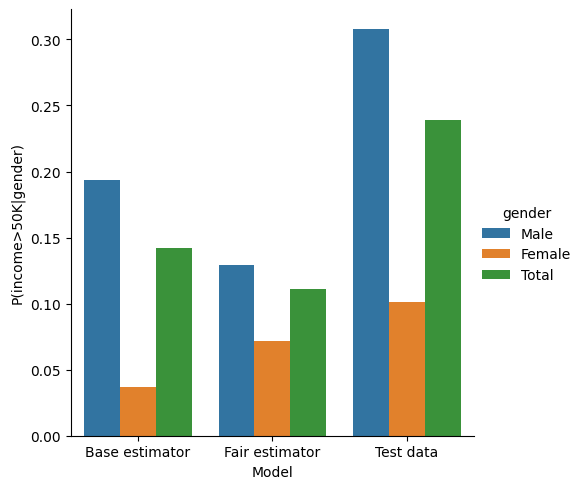

In [21]:
result_list = []

for i, y_col_val in enumerate(pipeline["y_encoder"].categories_[0]):
    for model_name, model in zip(["Base estimator", "Fair estimator", "Test data"], [estimator_wrapper.logistic_regression_estimator_, postprocessed_predictor_EO, None]):
        for gender_name, mask in zip(["Male", "Female", "Total"], [~sensitive_col_test, sensitive_col_test, np.ones_like(sensitive_col_test)]):
            y_col_name = f"income{y_col_val}"
            if model is None:
                predictions = adult_y_test
            elif isinstance(model, ThresholdOptimizer):
                predictions = model.predict(adult_X_test, sensitive_features=sensitive_col_test)
            else:
                predictions = model.predict(adult_X_test)
            result_list.append({
                "model": model_name,
                "target_col": y_col_name,
                "gender": gender_name,
                "mean_proba": (predictions[mask] == i).mean()
            })
    
result_df = pd.DataFrame(result_list)
# print(result_df)

val_to_show = "income>50K"
sns.catplot(data=result_df[result_df["target_col"] == val_to_show], x="model", y="mean_proba", hue="gender", kind="bar")
plt.xlabel("Model")
plt.ylabel(f"P({val_to_show}|gender)")
plt.show()

# CelebA

In [22]:
# celeba_path = "../data/celeba-dataset"
# if not os.path.exists(celeba_path):
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
# %mv $path $celeba_path

In [23]:
celeba_path = path
celeba_path

'/home/milos/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2'

In [24]:
import torch
import wandb
import torchvision
from tqdm import tqdm
import sklearn.model_selection
import torchvision.transforms as transforms

from torchvision.datasets.folder import default_loader
from torch.utils.data import Dataset

from typing import Optional, Callable, Any

In [25]:
def reduce_sensitive_entry_ratio(df, 
                                 sensitive_col, 
                                 outcome_col, 
                                 ratios_to_keep, 
                                 random_state=42):
    """
    Reduces the ratio of entries in a DataFrame for a specified sensitive column value.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    sensitive_col (str): The name of the column containing sensitive values.
    outcome_col (str): The name of the outcome column used for stratification.
    ratios_to_keep (dict): A dictionary where keys are sensitive column values and values are the ratios of entries to keep.
    random_state (int, optional): The random state for reproducibility. Default is 42.

    Returns:
    pd.DataFrame: A DataFrame with the reduced ratio of entries for the specified sensitive column value.
    """
    parts_list = []
    for sensitive_col_val, keep_ratio in ratios_to_keep.items():
        mask_to_change = df[sensitive_col] == sensitive_col_val
        entries_to_change = df[mask_to_change]
        if keep_ratio == 1:
            parts_list.append(entries_to_change)
        else:
            df_entries_to_keep, _ = sklearn.model_selection.train_test_split(
                entries_to_change,
                train_size=keep_ratio,
                random_state=random_state,
                stratify=entries_to_change[outcome_col])
            parts_list.append(df_entries_to_keep)
    return pd.concat(parts_list)

In [26]:
celeba_sensitive_col = "Male"
celeba_outcome_col = "Blond_Hair"
full_celeba_df = pd.read_csv(os.path.join(celeba_path, "list_attr_celeba.csv"))
# celeba_df = reduce_sensitive_entry_ratio(
#     full_celeba_df, 
#     celeba_sensitive_col, 
#     celeba_outcome_col, 
#     0.1, 
#     1, 
#     random_state=42)
for column in full_celeba_df.columns:
    if set(full_celeba_df[column].unique()) == {1, -1}:
        full_celeba_df[column] = full_celeba_df[column].replace(-1, 0)
celeba_strata_idx = 2 * full_celeba_df[celeba_outcome_col] + full_celeba_df[celeba_sensitive_col]
full_celeba_df["strata_id"] = celeba_strata_idx
print("Strata ratios:", full_celeba_df["strata_id"].value_counts(normalize=True))
full_celeba_df.head()

Strata ratios: strata_id
0    0.443887
1    0.408121
2    0.139359
3    0.008633
Name: proportion, dtype: float64


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,strata_id
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,1,1,0,1,0,1,0,0,1,0
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,0
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


In [27]:
def strata_proportions(df):
    series = df["strata_id"].value_counts(normalize=True)
    strata_id_to_group = {
        0: "Dark-Haired Women",
        1: "Dark-Haired Men",
        2: "Blond-Haired Women",
        3: "Blond-Haired Men",
        
    }
    series.index = series.index.map(strata_id_to_group)
    return series

sensitive_col_val_names = {
    0: "Female",
    1: "Male"
}
def keep_ratios_to_str(keep_ratios):
    return "-".join([
        f"{sensitive_col_val_names[i]}_frac={proportion}"
        for i, proportion in keep_ratios.items()
    ])

In [28]:
keep_ratios = {
    0: 1,
    1: 1,
}

train_size = 85000
test_size = 15000
val_size = 15000

celeba_nontest_df, celeba_test_df = sklearn.model_selection.train_test_split(
    full_celeba_df, test_size=test_size, stratify=full_celeba_df["strata_id"], random_state=42
)


celeba_trainval_df = reduce_sensitive_entry_ratio(
    celeba_nontest_df, 
    celeba_sensitive_col, 
    celeba_outcome_col, 
    keep_ratios, 
    random_state=42)

celeba_train_df, celeba_val_df = sklearn.model_selection.train_test_split(
    celeba_trainval_df, test_size=val_size, train_size=train_size, stratify=celeba_trainval_df["strata_id"], random_state=42
)

model_name_extension = keep_ratios_to_str(keep_ratios)

print("Train set proportions:", strata_proportions(celeba_train_df), end="\n\n")
print("Validation set proportions:", strata_proportions(celeba_val_df), end="\n\n")
print("Test set (always non-adjusted) proportions:", strata_proportions(celeba_test_df), end="\n\n")
print("Train, validation, test shapes:", celeba_train_df.shape, celeba_val_df.shape, celeba_test_df.shape)

Train set proportions: strata_id
Dark-Haired Women     0.443882
Dark-Haired Men       0.408118
Blond-Haired Women    0.139365
Blond-Haired Men      0.008635
Name: proportion, dtype: float64

Validation set proportions: strata_id
Dark-Haired Women     0.443933
Dark-Haired Men       0.408133
Blond-Haired Women    0.139333
Blond-Haired Men      0.008600
Name: proportion, dtype: float64

Test set (always non-adjusted) proportions: strata_id
Dark-Haired Women     0.443867
Dark-Haired Men       0.408133
Blond-Haired Women    0.139333
Blond-Haired Men      0.008667
Name: proportion, dtype: float64

Train, validation, test shapes: (85000, 42) (15000, 42) (15000, 42)


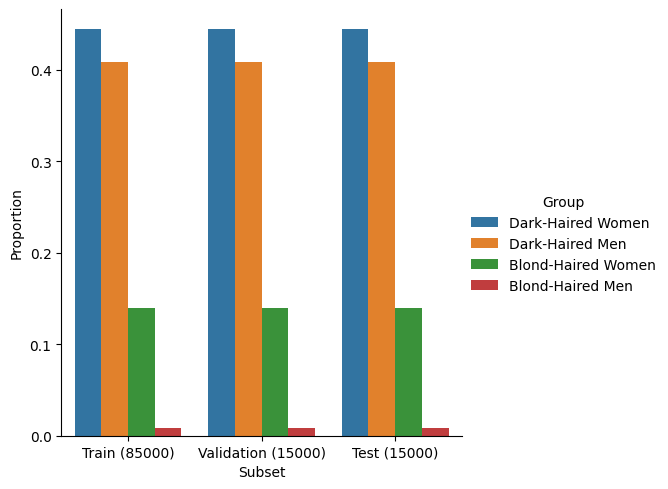

In [29]:
celeba_subset_dfs = {
    "Train": celeba_train_df,
    "Validation": celeba_val_df,
    "Test": celeba_test_df
}

proportions_df_list = []
for subset_name, df in celeba_subset_dfs.items():
    proportions = strata_proportions(df)
    
    proportions = proportions.to_frame().reset_index().rename(columns={"strata_id": "Group", "proportion": "Proportion"})
    proportions["Subset"] = f"{subset_name} ({len(df)})"
    
    proportions_df_list.append(proportions)
proportions_df = pd.concat(proportions_df_list)
sns.catplot(data=proportions_df, x="Subset", y="Proportion", hue="Group", kind="bar")
plt.show()

In [ ]:
from fairlearn.metrics import equalized_odds_difference, equalized_odds_ratio

class CelebAImageDataset(Dataset):
    """
    A custom Dataset class for loading images and their attributes from the CelebA dataset.
    Args:
        attr_df (pd.DataFrame): DataFrame containing image attributes and metadata.
        image_folder_path (str): Path to the folder containing the images.
        target_column (str): The column name in attr_df that contains the target labels.
        additional_attributes_to_provide (Optional[List[str] | str], optional): Additional attributes to provide along with the image and target. Defaults to None.
        transform (Optional[Callable], optional): A function/transform to apply to the images. Defaults to None.
        target_transform (Optional[Callable], optional): A function/transform to apply to the target labels. Defaults to None.
        additional_attributes_transform (Optional[Callable], optional): A function/transform to apply to the additional attributes. Defaults to None.
        loader (Callable[[str], Any], optional): A function to load an image given its path. Defaults to default_loader.
        enable_caching (bool, optional): Whether to cache the loaded samples. Defaults to False.
    Raises:
        ValueError: If the target column or additional attributes are not found in the DataFrame.
    Methods:
        __len__(): Returns the number of samples in the dataset.
        __getitem__(idx: int): Returns a tuple containing the image, target, and optionally additional attributes for the given index.
    """
    def __init__(self, 
                 attr_df, 
                 image_folder_path,
                 target_column, 
                 additional_attributes_to_provide: Optional[List[str] | str] = None,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,
                 additional_attributes_transform: Optional[Callable] = None,
                 loader: Callable[[str], Any] = default_loader,
                 enable_caching: bool = False):
        if target_column not in attr_df.columns:
            raise ValueError(f"Target column '{target_column}' not found in the DataFrame.")
        if additional_attributes_to_provide is not None:
            to_check_attributes = additional_attributes_to_provide
            if isinstance(additional_attributes_to_provide, str):
                to_check_attributes = [additional_attributes_to_provide]
            for attr in to_check_attributes:
                if attr not in attr_df.columns:
                    raise ValueError(f"Attribute '{attr}' not found in the DataFrame.")
        self.attr_df = attr_df
        self.image_folder_path = image_folder_path
        self.target_column = target_column
        self.additional_attributes_to_provide = additional_attributes_to_provide
        self.transform = transform
        self.target_transform = target_transform
        self.additional_attributes_transform = additional_attributes_transform
        self.loader = loader
        self.enable_caching = enable_caching
        self.__cache = {}
        
    def __len__(self) -> int:
        return len(self.attr_df)
    
    def __getitem__(self, idx: int):
        # Cache Lookup if enabled
        if self.enable_caching and idx in self.__cache:
            return self.__cache[idx]
        # Sample Loading
        entry = self.attr_df.iloc[idx]
        img_path = os.path.join(self.image_folder_path, entry["image_id"])
        img = self.loader(img_path)
        if self.transform is not None:
            img = self.transform(img)
        target = entry[self.target_column]
        if self.target_transform is not None:
            target = self.target_transform(target)
        # Preparing the result tuple
        if self.additional_attributes_to_provide is not None:
            additional_attributes = entry[self.additional_attributes_to_provide]
            if self.additional_attributes_transform is not None:
                additional_attributes = self.additional_attributes_transform(additional_attributes)
            if isinstance(additional_attributes, pd.Series):
                additional_attributes = additional_attributes.to_dict()
            result = (img, target, additional_attributes)
        else:
            result = (img, target)
        # Caching the result if enabled
        if self.enable_caching:
            self.__cache[idx] = result
        return result
    
def make_resnet18_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    input_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])
    return input_transform
    
def make_resnet18(num_classes: int, freeze_embeddings: bool = True, 
                  pretrained: bool = True) -> Tuple[torch.nn.Module, Callable]:
    """
    Creates a ResNet-18 model with the specified number of output classes and an input transformation pipeline.

    Args:
        num_classes (int): The number of output classes for the final fully connected layer.
        freeze_embeddings (bool, optional): If True, freezes the parameters of the model except for the final fully connected layer. Defaults to True.
        pretrained (bool, optional): If True, loads the model with pretrained weights on ImageNet. Defaults to True.

    Returns:
        Tuple[torch.nn.Module, Callable]: A tuple containing the ResNet-18 model and the input transformation pipeline.
    """
    # Create model
    weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
    model = torchvision.models.resnet18(weights=weights)
    for p in model.parameters():
        p.requires_grad = not freeze_embeddings
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    return model, make_resnet18_transform()

def optimal_device() -> torch.device:
    """
    Determines the optimal device for PyTorch operations.

    Returns:
        torch.device: The optimal device for computation. It returns a CUDA device if available,
                      otherwise it checks for an MPS (Metal Performance Shaders) device, and if neither
                      are available, it defaults to the CPU.
    """
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")
    
def eval_accuracy(model, eval_loader, criterion, device):
    """
    Evaluate the accuracy and loss of a given model on a provided evaluation data loader.
    Args:
        model (torch.nn.Module): The model to be evaluated.
        eval_loader (torch.utils.data.DataLoader): DataLoader containing the evaluation dataset.
        criterion (torch.nn.Module): Loss function used to compute the evaluation loss.
    Returns:
        tuple: A tuple containing:
            - accuracy (float): The accuracy of the model on the evaluation dataset.
            - eval_loss (float): The average loss of the model on the evaluation dataset.
    """
    correct, total = 0, 0
    eval_loss = 0
    model.eval()
    model.to(device)
    with torch.no_grad():
        for x, y, _ in tqdm(eval_loader, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)
            pred = model(x.to(device)).argmax(dim=1)
            correct += (pred == y.to(device)).sum().item()
            total += y.size(0)
            
            loss = criterion(model(x), y).item()
            eval_loss += loss * x.size(0)
    eval_loss = eval_loss / total
    accuracy = correct / total
    return accuracy, eval_loss

def eval_equalized_odds(model, eval_loader, device):
    """
    Evaluates the equalized odds of a given model on a provided evaluation dataset.
    Args:
        model (torch.nn.Module): The model to be evaluated.
        eval_loader (torch.utils.data.DataLoader): DataLoader for the evaluation dataset. (Must return x, y, sensitive_feature)
        device (torch.device): The device on which the model and data are loaded.
    Returns:
        tuple: A tuple containing:
            - equalized_odds_difference (float): The difference in equalized odds.
            - equalized_odds_ratio (float): The ratio of equalized odds.
    """
    
    predictions = []
    sensitive_mask = []
    ground_truths = []
    model.eval()
    model.to(device)
    with torch.no_grad():
        for x, y, sensitive in tqdm(eval_loader, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)
            pred = model(x.to(device)).argmax(dim=1)
            predictions.extend(pred.cpu().numpy())
            sensitive_mask.extend(sensitive.cpu().tolist())
            ground_truths.extend(y.cpu().tolist())
    return (
        equalized_odds_difference(ground_truths, predictions, sensitive_features=sensitive_mask),
        equalized_odds_ratio(ground_truths, predictions, sensitive_features=sensitive_mask)
    )

def train_model(model, optimizer, criterion, train_loader, validation_loader, device, num_epochs=10, best_model_save_path=None):
    """
    Trains a given model using the specified optimizer and loss criterion.

    Args:
        model (torch.nn.Module): The neural network model to be trained.
        optimizer (torch.optim.Optimizer): The optimization algorithm.
        criterion (torch.nn.Module): The loss function.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        validation_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        num_epochs (int, optional): Number of epochs to train the model. Default is 10.

    Returns:
        None
    """
    best_acc = -1
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        for x, y, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):    
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            wandb.log({"Training Loss": loss.item()})
        val_acc, val_loss = eval_accuracy(model, validation_loader, criterion, device)
        if val_acc > best_acc:
            best_acc = val_acc
            if best_model_save_path is not None:
                model.eval()
                print(f"Saving best model with accuracy: {best_acc} (Validation Loss: {val_loss})")
                torch.save(model.state_dict(), best_model_save_path)
        wandb.log({"Validation Accuracy": val_acc, "Validation Loss": val_loss})
        print(f"Epoch {epoch+1}: Validation Accuracy: {val_acc}, Validation Loss: {val_loss}")

In [31]:
IMAGE_DIR = os.path.join(celeba_path, "img_align_celeba", "img_align_celeba")
def full_training_loop(train_df, eval_df, config={}, save_path_name_func=None):
    default_config = {
        "pretrained": True,
        "freeze_embeddings": False,
        "num_classes": len(full_celeba_df[celeba_outcome_col].unique()),
        "batch_size": 1000,
        "learning_rate": 0.1,
        "momentum": 0.9,
        "optimizer": "SGD",
        "outcome_col": celeba_outcome_col,
        "epochs": 20,
        "save_point": "final",
    }
    config = {**default_config, **config}
    if save_path_name_func is not None:
        config["save_path"] = os.path.abspath(save_path_name_func(config))
    wandb.init(project="Audits CelebA ResNet18", config=config)

    model, image_pre_transform = make_resnet18(
        num_classes=wandb.config["num_classes"], 
        freeze_embeddings=wandb.config["freeze_embeddings"], pretrained=wandb.config["pretrained"])

    train_loader = torch.utils.data.DataLoader(
        CelebAImageDataset(train_df, 
                            IMAGE_DIR, 
                            wandb.config["outcome_col"],
                            additional_attributes_to_provide=celeba_sensitive_col,
                            transform=image_pre_transform,
                            enable_caching=True),
        batch_size=wandb.config["batch_size"], shuffle=True)

    validation_loader = torch.utils.data.DataLoader(
        CelebAImageDataset(eval_df, 
                            IMAGE_DIR, 
                            wandb.config["outcome_col"],
                            additional_attributes_to_provide=celeba_sensitive_col,
                            transform=image_pre_transform,
                            enable_caching=True),
        batch_size=wandb.config["batch_size"], shuffle=True)

    device = optimal_device()

    model = model.to(device)
    match wandb.config["optimizer"].lower():
        case "adam":
            if "momentum" in wandb.config:
                raise ValueError("Momentum should not be specified for the Adam optimizer.")
            optimizer = torch.optim.Adam(model.parameters(), lr=wandb.config["learning_rate"])
        case "sgd":
            optimizer = torch.optim.SGD(model.parameters(), lr=wandb.config["learning_rate"], momentum=wandb.config["momentum"])
        case _:
            raise ValueError("Invalid optimizer specified in the configuration.")
    criterion = torch.nn.CrossEntropyLoss()

    best_model_save_path = wandb.config.get("save_path", None) \
        if wandb.config["save_point"] == "best" else None
    train_model(model, optimizer, criterion, train_loader, validation_loader, device, 
                num_epochs=wandb.config["epochs"], best_model_save_path=best_model_save_path)
    if "save_path" in wandb.config and wandb.config["save_point"] == "final":
        torch.save(model.state_dict(), wandb.config["save_path"])
    # torch.save(model.state_dict(), f"../data/models/celeba_resnet18_freezing={wandb.config["freeze_embeddings"]}_outcomecol={wandb.config["outcome_col"]}_0.1originalmale.pth")
    wandb.finish()
    return model

### Collecting data for models trained on different columns

In [ ]:
celeba_sensitive_col = "Male"
possible_outcome_cols = set(
    full_celeba_df.columns).difference(["image_id", celeba_sensitive_col, "strata_id"])

train_size = 50000
test_size = 10000
val_size = 10000
epochs = 10

device = optimal_device()
image_pre_transform = make_resnet18_transform()

for outcome_col in possible_outcome_cols:
    celeba_strata_idx = 2 * full_celeba_df[outcome_col] + full_celeba_df[celeba_sensitive_col]
    full_celeba_df["strata_id"] = celeba_strata_idx
    print("Column:", outcome_col, "Strata ratios:", full_celeba_df["strata_id"].value_counts(normalize=True))
    
    celeba_nontest_df, celeba_test_df = sklearn.model_selection.train_test_split(
        full_celeba_df, test_size=test_size, stratify=full_celeba_df["strata_id"], random_state=42
    )
    celeba_train_df, celeba_val_df = sklearn.model_selection.train_test_split(
        celeba_nontest_df, test_size=val_size, train_size=train_size, stratify=celeba_nontest_df["strata_id"], random_state=42
    )
    
    config = {
        "outcome_col": outcome_col,
        "epochs": epochs,
        "num_classes": len(full_celeba_df[outcome_col].unique()),
        "outcome_col": outcome_col
    }
    
    model_path = f"../data/models/celeba_resnet18-feature_test-{outcome_col}.pth"
    
    model = full_training_loop(celeba_train_df, celeba_val_df, 
                       config=config, 
                       save_path_name_func=lambda config: model_path)
    
    model.eval()
    gt = []
    pred_probas = []
    sensitives = []
    with torch.no_grad():
        for x, y, sensitive in tqdm(torch.utils.data.DataLoader(
            CelebAImageDataset(celeba_test_df, 
                                IMAGE_DIR, 
                                config["outcome_col"],
                                additional_attributes_to_provide=celeba_sensitive_col,
                                transform=image_pre_transform,
                                enable_caching=True),
            batch_size=100, shuffle=False), desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)
            predict_proba = model(x)
            gt.extend(y.cpu().numpy())
            pred_probas.extend(predict_proba.cpu().numpy())
            sensitives.extend(sensitive.cpu().numpy())
            
    test_res_data = pd.concat({
        "Ground Truth": pd.Series(gt),
        "Predicted Probabilities": pd.Series(pred_probas),
        "Sensitive": pd.Series(sensitives)
    }, axis=1)
    test_res_data.to_csv(f"../data/col_res/data_{outcome_col}.csv")

Column: Black_Hair Strata ratios: strata_id
0    0.468161
1    0.292588
3    0.124166
2    0.115084
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.4112, Validation Loss: 0.9967436194419861


Epoch 2: Validation Accuracy: 0.8353, Validation Loss: 0.4900347739458084


Epoch 3: Validation Accuracy: 0.8236, Validation Loss: 0.37429967522621155


Epoch 4: Validation Accuracy: 0.8448, Validation Loss: 0.4899027943611145


Epoch 5: Validation Accuracy: 0.8626, Validation Loss: 0.34046525359153745


Epoch 6: Validation Accuracy: 0.8555, Validation Loss: 0.32665764093399047


Epoch 7: Validation Accuracy: 0.8551, Validation Loss: 0.3202053666114807


Epoch 8: Validation Accuracy: 0.8524, Validation Loss: 0.3356248289346695


Epoch 9: Validation Accuracy: 0.8231, Validation Loss: 0.37646144032478335


Epoch 10: Validation Accuracy: 0.8659, Validation Loss: 0.30577838122844697


Training Loss,█▂▂▂▂▂▂▃▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁█▇█████▇█
Validation Loss,█▃▂▃▁▁▁▁▂▁
Training Loss,0.25106
Validation Accuracy,0.8659
Validation Loss,0.30578


Column: Big_Nose Strata ratios: strata_id
0    0.523596
1    0.241872
3    0.174882
2    0.059650
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.7655, Validation Loss: 1.2706468760967256


Epoch 2: Validation Accuracy: 0.7655, Validation Loss: 0.5501459062099456


Epoch 3: Validation Accuracy: 0.7649, Validation Loss: 0.5418996930122375


Epoch 4: Validation Accuracy: 0.7645, Validation Loss: 0.5451363503932953


Epoch 5: Validation Accuracy: 0.7655, Validation Loss: 0.5537975311279297


Epoch 6: Validation Accuracy: 0.7655, Validation Loss: 0.575030505657196


Epoch 7: Validation Accuracy: 0.7649, Validation Loss: 0.5456397712230683


Epoch 8: Validation Accuracy: 0.7619, Validation Loss: 0.5643491953611374


Epoch 9: Validation Accuracy: 0.7277, Validation Loss: 0.7255185544490814


Epoch 10: Validation Accuracy: 0.762, Validation Loss: 0.5740672945976257


Training Loss,▅█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,███████▇▁▇
Validation Loss,█▁▁▁▁▁▁▁▃▁
Training Loss,0.51209
Validation Accuracy,0.762
Validation Loss,0.57407


Column: Pale_Skin Strata ratios: strata_id
0    0.550447
1    0.406606
2    0.032799
3    0.010148
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.957, Validation Loss: 20.09345464706421


Epoch 2: Validation Accuracy: 0.9611, Validation Loss: 0.13092197105288506


Epoch 3: Validation Accuracy: 0.9589, Validation Loss: 0.33803344070911406


Epoch 4: Validation Accuracy: 0.9573, Validation Loss: 0.22036555260419846


Epoch 5: Validation Accuracy: 0.967, Validation Loss: 0.09077908843755722


Epoch 6: Validation Accuracy: 0.9653, Validation Loss: 0.10313271433115005


Epoch 7: Validation Accuracy: 0.9689, Validation Loss: 0.0887740433216095


Epoch 8: Validation Accuracy: 0.9668, Validation Loss: 0.09122666642069817


Epoch 9: Validation Accuracy: 0.9535, Validation Loss: 0.11201945468783378


Epoch 10: Validation Accuracy: 0.9653, Validation Loss: 0.09580973535776138


Training Loss,█▂▁▃▂▁▂▂▂▂▂▁▂▂▂▁▂▂▁▁▂▁▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁
Validation Accuracy,▃▄▃▃▇▆█▇▁▆
Validation Loss,█▁▁▁▁▁▁▁▁▁
Training Loss,0.06655
Validation Accuracy,0.9653
Validation Loss,0.09581


Column: Mouth_Slightly_Open Strata ratios: strata_id
2    0.306497
0    0.276749
1    0.239823
3    0.176931
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.8219, Validation Loss: 0.42083875834941864


Epoch 2: Validation Accuracy: 0.5193, Validation Loss: 13.036240100860596


Epoch 3: Validation Accuracy: 0.9063, Validation Loss: 0.22343344390392303


Epoch 4: Validation Accuracy: 0.9326, Validation Loss: 0.16529676616191863


Epoch 5: Validation Accuracy: 0.9285, Validation Loss: 0.166928431391716


Epoch 6: Validation Accuracy: 0.9363, Validation Loss: 0.1565522998571396


Epoch 7: Validation Accuracy: 0.931, Validation Loss: 0.16884908229112625


Epoch 8: Validation Accuracy: 0.9366, Validation Loss: 0.15637437254190445


Epoch 9: Validation Accuracy: 0.9357, Validation Loss: 0.15378474444150925


Epoch 10: Validation Accuracy: 0.9299, Validation Loss: 0.1694292426109314


Training Loss,▄▃█▄▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▆▁▇███████
Validation Loss,▁█▁▁▁▁▁▁▁▁
Training Loss,0.16151
Validation Accuracy,0.9299
Validation Loss,0.16943


Column: Receding_Hairline Strata ratios: strata_id
0    0.552397
1    0.367825
3    0.048929
2    0.030849
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.9304, Validation Loss: 0.16038672029972076


Epoch 2: Validation Accuracy: 0.935, Validation Loss: 0.15092008262872697


Epoch 3: Validation Accuracy: 0.9368, Validation Loss: 0.1496524527668953


Epoch 4: Validation Accuracy: 0.9379, Validation Loss: 0.15370360910892486


Epoch 5: Validation Accuracy: 0.9398, Validation Loss: 0.15902467742562293


Epoch 6: Validation Accuracy: 0.9365, Validation Loss: 0.17632741630077362


Epoch 7: Validation Accuracy: 0.9347, Validation Loss: 0.21647433042526246


Epoch 8: Validation Accuracy: 0.9316, Validation Loss: 0.20125531405210495


Epoch 9: Validation Accuracy: 0.9318, Validation Loss: 0.2518302261829376


Epoch 10: Validation Accuracy: 0.9204, Validation Loss: 0.29124165922403333


Training Loss,█▅▇▆▇▆▆▅▅▅▅▅▅▄▅▃▅▄▅▅▃▃▃▄▆▄▃▃▃▂▂▃▁▂▂▂▂▂▁▁
Validation Accuracy,▅▆▇▇█▇▆▅▅▁
Validation Loss,▂▁▁▁▁▂▄▄▆█
Training Loss,0.03944
Validation Accuracy,0.9204
Validation Loss,0.29124


Column: Double_Chin Strata ratios: strata_id
0    0.577599
1    0.375713
3    0.041042
2    0.005647
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.9533, Validation Loss: 390.23759765625


Epoch 2: Validation Accuracy: 0.9533, Validation Loss: 0.1924944430589676


Epoch 3: Validation Accuracy: 0.9533, Validation Loss: 0.1896614044904709


Epoch 4: Validation Accuracy: 0.9533, Validation Loss: 0.18846602290868758


Epoch 5: Validation Accuracy: 0.9533, Validation Loss: 0.18869657665491105


Epoch 6: Validation Accuracy: 0.9533, Validation Loss: 0.1894266977906227


Epoch 7: Validation Accuracy: 0.9533, Validation Loss: 0.1887293204665184


Epoch 8: Validation Accuracy: 0.9533, Validation Loss: 0.18783808797597884


Epoch 9: Validation Accuracy: 0.9533, Validation Loss: 0.18973728716373445


Epoch 10: Validation Accuracy: 0.9532, Validation Loss: 0.18779851794242858


Training Loss,▅█▄▄▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,█████████▁
Validation Loss,█▁▁▁▁▁▁▁▁▁
Training Loss,0.1822
Validation Accuracy,0.9532
Validation Loss,0.1878


Column: Smiling Strata ratios: strata_id
2    0.315258
0    0.267988
1    0.249932
3    0.166822
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.8291, Validation Loss: 0.43875451683998107


Epoch 2: Validation Accuracy: 0.9105, Validation Loss: 0.20939587354660033


Epoch 3: Validation Accuracy: 0.9185, Validation Loss: 0.19346497654914857


Epoch 4: Validation Accuracy: 0.9199, Validation Loss: 0.19052085876464844


Epoch 5: Validation Accuracy: 0.9203, Validation Loss: 0.18478755056858062


Epoch 6: Validation Accuracy: 0.9182, Validation Loss: 0.19446429014205932


Epoch 7: Validation Accuracy: 0.9099, Validation Loss: 0.2229204699397087


Epoch 8: Validation Accuracy: 0.924, Validation Loss: 0.17825287133455275


Epoch 9: Validation Accuracy: 0.9201, Validation Loss: 0.18634431958198547


Epoch 10: Validation Accuracy: 0.9248, Validation Loss: 0.17696980834007264


Training Loss,█▆▅▅▃▂▂▂▂▂▂▂▁▂▂▁▂▂▂▂▁▂▁▂▁▁▁▂▁▁▂▁▁▁▁▂▂▁▁▁
Validation Accuracy,▁▇████▇███
Validation Loss,█▂▁▁▁▁▂▁▁▁
Training Loss,0.16572
Validation Accuracy,0.9248
Validation Loss,0.17697


Column: Eyeglasses Strata ratios: strata_id
0    0.569845
1    0.365036
3    0.051718
2    0.013401
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.9731, Validation Loss: 0.40696159303188323


Epoch 2: Validation Accuracy: 0.9896, Validation Loss: 0.033915622532367705


Epoch 3: Validation Accuracy: 0.9935, Validation Loss: 0.031439033802598715


Epoch 4: Validation Accuracy: 0.9926, Validation Loss: 0.027854279335588216


Epoch 5: Validation Accuracy: 0.994, Validation Loss: 0.023484738916158675


Epoch 6: Validation Accuracy: 0.9915, Validation Loss: 0.05391163444146514


Epoch 7: Validation Accuracy: 0.9939, Validation Loss: 0.02952568093314767


Epoch 8: Validation Accuracy: 0.9924, Validation Loss: 0.06867033606395126


Epoch 9: Validation Accuracy: 0.9939, Validation Loss: 0.036674375738948585


Epoch 10: Validation Accuracy: 0.992, Validation Loss: 0.060901072435081006


Training Loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▇███▇█▇█▇
Validation Loss,█▁▁▁▁▂▁▂▁▂
Training Loss,0.00075
Validation Accuracy,0.992
Validation Loss,0.0609


Column: Chubby Strata ratios: strata_id
0    0.576138
1    0.366295
3    0.050459
2    0.007108
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.9424, Validation Loss: 2.9157371878623963


Epoch 2: Validation Accuracy: 0.9424, Validation Loss: 0.22333501130342484


Epoch 3: Validation Accuracy: 0.9423, Validation Loss: 0.21962545216083526


Epoch 4: Validation Accuracy: 0.9424, Validation Loss: 0.22514234632253646


Epoch 5: Validation Accuracy: 0.9392, Validation Loss: 0.22396574020385743


Epoch 6: Validation Accuracy: 0.9425, Validation Loss: 0.21815797686576843


Epoch 7: Validation Accuracy: 0.9425, Validation Loss: 0.21797749549150466


Epoch 8: Validation Accuracy: 0.9424, Validation Loss: 0.21753146052360534


Epoch 9: Validation Accuracy: 0.9424, Validation Loss: 0.21910407543182372


Epoch 10: Validation Accuracy: 0.9424, Validation Loss: 0.21694158315658568


Training Loss,▃█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,████▁█████
Validation Loss,█▁▁▁▁▁▁▁▁▁
Training Loss,0.24012
Validation Accuracy,0.9424
Validation Loss,0.21694


Column: Blond_Hair Strata ratios: strata_id
0    0.443887
1    0.408121
2    0.139359
3    0.008633
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.8151, Validation Loss: 0.51267791390419


Epoch 2: Validation Accuracy: 0.9194, Validation Loss: 0.19406580030918122


Epoch 3: Validation Accuracy: 0.936, Validation Loss: 0.15082713663578035


Epoch 4: Validation Accuracy: 0.9463, Validation Loss: 0.13169140443205835


Epoch 5: Validation Accuracy: 0.9519, Validation Loss: 0.11776610240340232


Epoch 6: Validation Accuracy: 0.9515, Validation Loss: 0.11715677976608277


Epoch 7: Validation Accuracy: 0.9492, Validation Loss: 0.12637560889124871


Epoch 8: Validation Accuracy: 0.954, Validation Loss: 0.11459714844822884


Epoch 9: Validation Accuracy: 0.9492, Validation Loss: 0.1286331109702587


Epoch 10: Validation Accuracy: 0.9522, Validation Loss: 0.12204694896936416


Training Loss,█▆▃▃▃▅▂▂▃▂▂▁▂▂▂▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▆▇███████
Validation Loss,█▂▂▁▁▁▁▁▁▁
Training Loss,0.08363
Validation Accuracy,0.9522
Validation Loss,0.12205


Column: Wearing_Hat Strata ratios: strata_id
0    0.568700
1    0.382840
3    0.033914
2    0.014546
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.9515, Validation Loss: 23.270051956176758


Epoch 2: Validation Accuracy: 0.9515, Validation Loss: 0.16928000450134278


Epoch 3: Validation Accuracy: 0.9518, Validation Loss: 0.17575479596853255


Epoch 4: Validation Accuracy: 0.9551, Validation Loss: 0.1487258106470108


Epoch 5: Validation Accuracy: 0.9621, Validation Loss: 0.20165739506483077


Epoch 6: Validation Accuracy: 0.9705, Validation Loss: 0.20959592163562774


Epoch 7: Validation Accuracy: 0.9731, Validation Loss: 0.16650787815451623


Epoch 8: Validation Accuracy: 0.976, Validation Loss: 0.16233172714710237


Epoch 9: Validation Accuracy: 0.972, Validation Loss: 0.15493797548115254


Epoch 10: Validation Accuracy: 0.9747, Validation Loss: 0.1447401974350214


Training Loss,▆▁▂█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▂▄▆▇█▇█
Validation Loss,█▁▁▁▁▁▁▁▁▁
Training Loss,0.04657
Validation Accuracy,0.9747
Validation Loss,0.14474


Column: Young Strata ratios: strata_id
2    0.509810
3    0.263807
1    0.152947
0    0.073436
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.7735, Validation Loss: 83.09721221923829


Epoch 2: Validation Accuracy: 0.7725, Validation Loss: 0.5416504740715027


Epoch 3: Validation Accuracy: 0.7723, Validation Loss: 0.5210092306137085


Epoch 4: Validation Accuracy: 0.7736, Validation Loss: 0.5737965881824494


Epoch 5: Validation Accuracy: 0.7736, Validation Loss: 0.5353046357631683


Epoch 6: Validation Accuracy: 0.7736, Validation Loss: 0.5340926140546799


Epoch 7: Validation Accuracy: 0.7736, Validation Loss: 0.5252872675657272


Epoch 8: Validation Accuracy: 0.7733, Validation Loss: 0.567229586839676


Epoch 9: Validation Accuracy: 0.772, Validation Loss: 0.5231577068567276


Epoch 10: Validation Accuracy: 0.7701, Validation Loss: 0.5852437078952789


Training Loss,▂█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,█▆▅████▇▅▁
Validation Loss,█▁▁▁▁▁▁▁▁▁
Training Loss,0.56754
Validation Accuracy,0.7701
Validation Loss,0.58524


Column: Mustache Strata ratios: strata_id
0    0.583231
1    0.375224
3    0.041530
2    0.000015
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.9585, Validation Loss: 10.296706199645996


Epoch 2: Validation Accuracy: 0.9585, Validation Loss: 0.16855172365903853


Epoch 3: Validation Accuracy: 0.9585, Validation Loss: 0.16312760040163993


Epoch 4: Validation Accuracy: 0.9585, Validation Loss: 0.149425358325243


Epoch 5: Validation Accuracy: 0.9585, Validation Loss: 0.13950161039829254


Epoch 6: Validation Accuracy: 0.9585, Validation Loss: 0.12805824875831603


Epoch 7: Validation Accuracy: 0.9585, Validation Loss: 0.11830087304115296


Epoch 8: Validation Accuracy: 0.9584, Validation Loss: 0.12593231573700905


Epoch 9: Validation Accuracy: 0.9576, Validation Loss: 0.1128253161907196


Epoch 10: Validation Accuracy: 0.9581, Validation Loss: 0.1077592320740223


Training Loss,█▄▄▁▁▅▃▂▂▁▂▂▂▂▁▁▂▂▂▁▁▁▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,███████▇▁▅
Validation Loss,█▁▁▁▁▁▁▁▁▁
Training Loss,0.09482
Validation Accuracy,0.9581
Validation Loss,0.10776


Column: Wearing_Lipstick Strata ratios: strata_id
2    0.469854
1    0.414173
0    0.113391
3    0.002581
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.8908, Validation Loss: 1.1980346202850343


Epoch 2: Validation Accuracy: 0.8576, Validation Loss: 0.2896655976772308


Epoch 3: Validation Accuracy: 0.9236, Validation Loss: 0.20440011769533156


Epoch 4: Validation Accuracy: 0.9332, Validation Loss: 0.151947420835495


Epoch 5: Validation Accuracy: 0.9357, Validation Loss: 0.15049216151237488


Epoch 6: Validation Accuracy: 0.9348, Validation Loss: 0.15183125138282777


Epoch 7: Validation Accuracy: 0.9282, Validation Loss: 0.17557190358638763


Epoch 8: Validation Accuracy: 0.9348, Validation Loss: 0.1590665638446808


Epoch 9: Validation Accuracy: 0.9319, Validation Loss: 0.17550245225429534


Epoch 10: Validation Accuracy: 0.9137, Validation Loss: 0.2367781400680542


Training Loss,█▂▆▆▃▂▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▄▁▇███▇██▆
Validation Loss,█▂▁▁▁▁▁▁▁▂
Training Loss,0.12053
Validation Accuracy,0.9137
Validation Loss,0.23678


Column: High_Cheekbones Strata ratios: strata_id
2    0.326813
1    0.288535
0    0.256433
3    0.128219
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.4844, Validation Loss: 6.979174661636352


Epoch 2: Validation Accuracy: 0.6862, Validation Loss: 0.7839187145233154


Epoch 3: Validation Accuracy: 0.7479, Validation Loss: 0.5482694655656815


Epoch 4: Validation Accuracy: 0.8202, Validation Loss: 0.40773487389087676


Epoch 5: Validation Accuracy: 0.8295, Validation Loss: 0.3854604184627533


Epoch 6: Validation Accuracy: 0.8433, Validation Loss: 0.36507770121097566


Epoch 7: Validation Accuracy: 0.8466, Validation Loss: 0.36050363779067995


Epoch 8: Validation Accuracy: 0.8459, Validation Loss: 0.3640778511762619


Epoch 9: Validation Accuracy: 0.85, Validation Loss: 0.36591182053089144


Epoch 10: Validation Accuracy: 0.8536, Validation Loss: 0.34248831272125246


Training Loss,▅█▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▅▆▇██████
Validation Loss,█▁▁▁▁▁▁▁▁▁
Training Loss,0.28986
Validation Accuracy,0.8536
Validation Loss,0.34249


Column: Wearing_Earrings Strata ratios: strata_id
1    0.410096
0    0.400979
2    0.182266
3    0.006658
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.7962, Validation Loss: 0.5438890159130096


Epoch 2: Validation Accuracy: 0.5929, Validation Loss: 102.63559646606446


Epoch 3: Validation Accuracy: 0.8111, Validation Loss: 0.48484624922275543


Epoch 4: Validation Accuracy: 0.811, Validation Loss: 0.4851783990859985


Epoch 5: Validation Accuracy: 0.8111, Validation Loss: 0.4896083325147629


Epoch 6: Validation Accuracy: 0.8093, Validation Loss: 0.48620243966579435


Epoch 7: Validation Accuracy: 0.8111, Validation Loss: 0.4862626910209656


Epoch 8: Validation Accuracy: 0.8111, Validation Loss: 0.48638142049312594


Epoch 9: Validation Accuracy: 0.8111, Validation Loss: 0.4907673329114914


Epoch 10: Validation Accuracy: 0.8111, Validation Loss: 0.48496062159538267


Training Loss,▁█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,█▁████████
Validation Loss,▁█▁▁▁▁▁▁▁▁
Training Loss,0.46991
Validation Accuracy,0.8111
Validation Loss,0.48496


Column: Wavy_Hair Strata ratios: strata_id
1    0.358057
0    0.322376
2    0.260870
3    0.058697
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.6804, Validation Loss: 6.600560235977173


Epoch 2: Validation Accuracy: 0.6804, Validation Loss: 0.644736510515213


Epoch 3: Validation Accuracy: 0.6804, Validation Loss: 0.6236892223358155


Epoch 4: Validation Accuracy: 0.6802, Validation Loss: 0.644130426645279


Epoch 5: Validation Accuracy: 0.6804, Validation Loss: 0.715459680557251


Epoch 6: Validation Accuracy: 0.6804, Validation Loss: 0.6316984593868256


Epoch 7: Validation Accuracy: 0.6804, Validation Loss: 1.8721178889274597


Epoch 8: Validation Accuracy: 0.6804, Validation Loss: 0.6240665316581726


Epoch 9: Validation Accuracy: 0.6802, Validation Loss: 0.6356900811195374


Epoch 10: Validation Accuracy: 0.678, Validation Loss: 0.6496944785118103


Training Loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,███▇████▇▁
Validation Loss,█▁▁▁▁▁▂▁▁▁
Training Loss,0.62415
Validation Accuracy,0.678
Validation Loss,0.64969


Column: Goatee Strata ratios: strata_id
0    0.583182
1    0.354054
3    0.062700
2    0.000064
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.9372, Validation Loss: 10.787933778762817


Epoch 2: Validation Accuracy: 0.9367, Validation Loss: 2.121388006210327


Epoch 3: Validation Accuracy: 0.9372, Validation Loss: 0.42151969373226167


Epoch 4: Validation Accuracy: 0.9372, Validation Loss: 0.23276671916246414


Epoch 5: Validation Accuracy: 0.9372, Validation Loss: 0.22985129058361053


Epoch 6: Validation Accuracy: 0.9372, Validation Loss: 0.2278009831905365


Epoch 7: Validation Accuracy: 0.9372, Validation Loss: 0.22583378255367278


Epoch 8: Validation Accuracy: 0.9372, Validation Loss: 0.22496461719274521


Epoch 9: Validation Accuracy: 0.9372, Validation Loss: 0.22200827449560165


Epoch 10: Validation Accuracy: 0.9372, Validation Loss: 0.2193235605955124


Training Loss,█▃▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,█▁████████
Validation Loss,█▂▁▁▁▁▁▁▁▁
Training Loss,0.21585
Validation Accuracy,0.9372
Validation Loss,0.21932


Column: Big_Lips Strata ratios: strata_id
0    0.407500
1    0.351705
2    0.175746
3    0.065050
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.7592, Validation Loss: 0.7721365690231323


Epoch 2: Validation Accuracy: 0.7592, Validation Loss: 0.712527620792389


Epoch 3: Validation Accuracy: 0.7592, Validation Loss: 0.5877890110015869


Epoch 4: Validation Accuracy: 0.7592, Validation Loss: 0.5665023624897003


Epoch 5: Validation Accuracy: 0.7592, Validation Loss: 0.5531716585159302


Epoch 6: Validation Accuracy: 0.7589, Validation Loss: 0.5509762644767762


Epoch 7: Validation Accuracy: 0.7592, Validation Loss: 0.5496664643287659


Epoch 8: Validation Accuracy: 0.7592, Validation Loss: 0.5493423283100128


Epoch 9: Validation Accuracy: 0.7592, Validation Loss: 0.5509634196758271


Epoch 10: Validation Accuracy: 0.7592, Validation Loss: 0.5551406919956208


Training Loss,▃█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,█████▁████
Validation Loss,█▆▂▂▁▁▁▁▁▁
Training Loss,0.55967
Validation Accuracy,0.7592
Validation Loss,0.55514


Column: Wearing_Necklace Strata ratios: strata_id
0    0.467717
1    0.409316
2    0.115529
3    0.007438
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.877, Validation Loss: 14.662830829620361


Epoch 2: Validation Accuracy: 0.877, Validation Loss: 0.3937958270311356


Epoch 3: Validation Accuracy: 0.877, Validation Loss: 0.3770799845457077


Epoch 4: Validation Accuracy: 0.877, Validation Loss: 0.3719363033771515


Epoch 5: Validation Accuracy: 0.877, Validation Loss: 0.37110479474067687


Epoch 6: Validation Accuracy: 0.877, Validation Loss: 0.3703616201877594


Epoch 7: Validation Accuracy: 0.877, Validation Loss: 0.3730027586221695


Epoch 8: Validation Accuracy: 0.877, Validation Loss: 0.36564371585845945


Epoch 9: Validation Accuracy: 0.877, Validation Loss: 0.36173381805419924


Epoch 10: Validation Accuracy: 0.877, Validation Loss: 0.37141574919223785


Training Loss,▆█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▁▁▁▁▁▁▁▁▁
Training Loss,0.35961
Validation Accuracy,0.877
Validation Loss,0.37142


Column: Straight_Hair Strata ratios: strata_id
0    0.475886
1    0.315712
2    0.107360
3    0.101042
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.7916, Validation Loss: 1.8189935207366943


Epoch 2: Validation Accuracy: 0.7894, Validation Loss: 0.5142143338918685


Epoch 3: Validation Accuracy: 0.7916, Validation Loss: 0.5411826938390731


Epoch 4: Validation Accuracy: 0.7895, Validation Loss: 0.5140201151371002


Epoch 5: Validation Accuracy: 0.7907, Validation Loss: 0.5126091241836548


Epoch 6: Validation Accuracy: 0.7916, Validation Loss: 0.5101679235696792


Epoch 7: Validation Accuracy: 0.7916, Validation Loss: 0.5100328326225281


Epoch 8: Validation Accuracy: 0.7917, Validation Loss: 0.5102088481187821


Epoch 9: Validation Accuracy: 0.7916, Validation Loss: 0.5088887989521027


Epoch 10: Validation Accuracy: 0.7916, Validation Loss: 0.5077155232429504


Training Loss,█▄▄▂▂▂▁▁▁▁▁▁▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,█▁█▁▅█████
Validation Loss,█▁▁▁▁▁▁▁▁▁
Training Loss,0.50972
Validation Accuracy,0.7916
Validation Loss,0.50772


Column: Wearing_Necktie Strata ratios: strata_id
0    0.583073
1    0.344212
3    0.072542
2    0.000173
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.9313, Validation Loss: 0.16767824590206146


Epoch 2: Validation Accuracy: 0.9463, Validation Loss: 0.13223475441336632


Epoch 3: Validation Accuracy: 0.9514, Validation Loss: 0.12469843849539756


Epoch 4: Validation Accuracy: 0.9372, Validation Loss: 0.1476961776614189


Epoch 5: Validation Accuracy: 0.9255, Validation Loss: 0.17054634392261506


Epoch 6: Validation Accuracy: 0.9412, Validation Loss: 0.15058165937662124


Epoch 7: Validation Accuracy: 0.9426, Validation Loss: 0.14571887627243996


Epoch 8: Validation Accuracy: 0.9468, Validation Loss: 0.22494918555021287


Epoch 9: Validation Accuracy: 0.9452, Validation Loss: 0.3821563109755516


Epoch 10: Validation Accuracy: 0.9479, Validation Loss: 0.282982836663723


Training Loss,██▆▅▇▆▆▅▅▅▄▅▄▄▄▄▅▄▃▅▄▄▃▃▃▃▃▃▃▂▂▃▃▂▃▁▂▁▂▁
Validation Accuracy,▃▇█▄▁▅▆▇▆▇
Validation Loss,▂▁▁▂▂▂▂▄█▅
Training Loss,0.03166
Validation Accuracy,0.9479
Validation Loss,0.28298


Column: Bags_Under_Eyes Strata ratios: strata_id
0    0.523808
1    0.271620
3    0.145134
2    0.059438
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.7954, Validation Loss: 141.14681549072264


Epoch 2: Validation Accuracy: 0.746, Validation Loss: 4.230478048324585


Epoch 3: Validation Accuracy: 0.7954, Validation Loss: 0.5199951350688934


Epoch 4: Validation Accuracy: 0.7954, Validation Loss: 0.7865018635988236


Epoch 5: Validation Accuracy: 0.7954, Validation Loss: 0.7564405858516693


Epoch 6: Validation Accuracy: 0.7954, Validation Loss: 0.5613366484642028


Epoch 7: Validation Accuracy: 0.7954, Validation Loss: 0.5198863267898559


Epoch 8: Validation Accuracy: 0.7942, Validation Loss: 0.5089720636606216


Epoch 9: Validation Accuracy: 0.7954, Validation Loss: 0.5183812350034713


Epoch 10: Validation Accuracy: 0.7847, Validation Loss: 0.5511524021625519


Training Loss,▅█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,█▁███████▆
Validation Loss,█▁▁▁▁▁▁▁▁▁
Training Loss,0.48712
Validation Accuracy,0.7847
Validation Loss,0.55115


Column: Rosy_Cheeks Strata ratios: strata_id
0    0.518778
1    0.415501
2    0.064467
3    0.001254
Name: proportion, dtype: float64


Epoch 1: Validation Accuracy: 0.9343, Validation Loss: 1.5754055976867676


Epoch 2: Validation Accuracy: 0.9343, Validation Loss: 0.2380019322037697


Epoch 3: Validation Accuracy: 0.9343, Validation Loss: 0.23160074204206466


Epoch 4: Validation Accuracy: 0.9343, Validation Loss: 0.21124855875968934


Epoch 5: Validation Accuracy: 0.9343, Validation Loss: 0.20019702166318892


Epoch 6: Validation Accuracy: 0.9359, Validation Loss: 0.17109508216381072


Epoch 7:  80%|████████  | 40/50 [00:43<00:10,  1.09s/it]

In [83]:
col_data_path_format = "../data/col_res/data_{}.csv"
possible_outcome_cols = set(
    full_celeba_df.columns).difference(["image_id", celeba_sensitive_col, "strata_id"])

def str_to_list(s):
    return list(map(lambda x: float(x), s[1:-1].strip().split()))

col_data = {}

for col in possible_outcome_cols:
    col_data_filepath = col_data_path_format.format(col)
    if not os.path.isfile(col_data_filepath):
        print(f"Missing data for {col}")
        continue
    col_prediction_data = pd.read_csv(col_data_path_format.format(col), index_col=0)
    predictions =\
       np.array(col_prediction_data["Predicted Probabilities"].apply(str_to_list).to_list())
    ground_truths = col_prediction_data["Ground Truth"].to_numpy()
    sensitive_col = col_prediction_data["Sensitive"].to_numpy()
    col_data[col] = {
        "predictions": predictions,
        "ground_truths": ground_truths,
        "sensitive_col": sensitive_col
    }

Missing data for Sideburns


In [103]:
from fairlearn.metrics import equalized_odds_difference, equalized_odds_ratio

col_metrics_list = []
for col, data in col_data.items():
    predictions = data["predictions"].argmax(axis=1)
    accuracy = (predictions == data["ground_truths"]).mean()
    
    conf_mat = sklearn.metrics.confusion_matrix(data["ground_truths"], predictions)
    eq_odds_diff = equalized_odds_difference(
        data["ground_truths"], 
        predictions, 
        sensitive_features=data["sensitive_col"]
    )
    eq_odds_ratio = equalized_odds_ratio(
        data["ground_truths"], 
        predictions, 
        sensitive_features=data["sensitive_col"]
    )
    
    strata_count = sklearn.metrics.confusion_matrix(data["sensitive_col"], predictions) / predictions.shape[0]
    smallest_population_proportion = strata_count.min()
    
    col_metrics_list.append({
        "Column": col,
        "Accuracy": accuracy,
        "Equalized Odds Difference": eq_odds_diff,
        "Equalized Odds Ratio": eq_odds_ratio,
        "Smallest Population Proportion": smallest_population_proportion
    })
    
col_metrics_df = pd.DataFrame(col_metrics_list)
attributes_with_enough_data_mask = col_metrics_df["Smallest Population Proportion"] > 0.05
col_metrics_df = col_metrics_df[attributes_with_enough_data_mask]\
    .sort_values("Equalized Odds Difference", ascending=False)
col_metrics_df.head()

,Column,Accuracy,Equalized Odds Difference,Equalized Odds Ratio,Smallest Population Proportion
7,High_Cheekbones,0.8528,0.136792,0.847687,0.1415
16,Smiling,0.9256,0.062344,0.898860,0.1529
4,Mouth_Slightly_Open,0.9269,0.028029,0.968964,0.1648
14,Black_Hair,0.8711,0.027824,0.804219,0.0915


High_Cheekbones offers a lot of entities in each strata while also having high equalized odds difference. Now, let's train a model on it.

np.int64(84434)

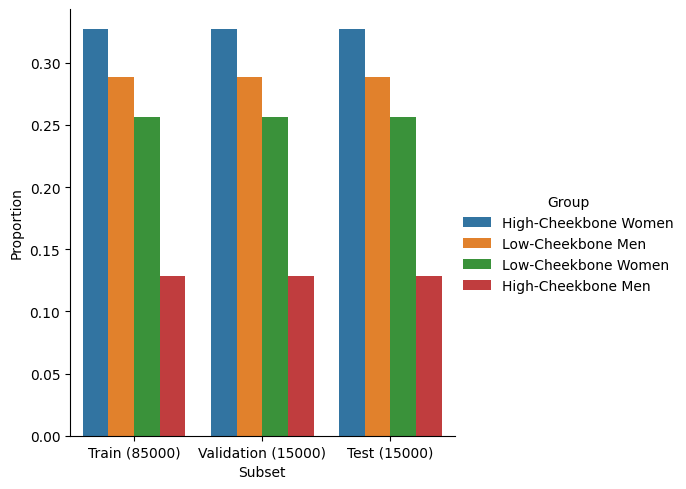

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /home/milos/.netrc


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/milos/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


Saving best model with accuracy: 0.545 (Validation Loss: 0.9749374190966288)
Epoch 1: Validation Accuracy: 0.545, Validation Loss: 0.9749374190966288


Epoch 2: Validation Accuracy: 0.545, Validation Loss: 0.6894803086916605


Epoch 3: Validation Accuracy: 0.545, Validation Loss: 0.6855804721514384


Saving best model with accuracy: 0.5451333333333334 (Validation Loss: 0.6825532595316569)
Epoch 4: Validation Accuracy: 0.5451333333333334, Validation Loss: 0.6825532595316569


Saving best model with accuracy: 0.5703333333333334 (Validation Loss: 0.7741280754407247)
Epoch 5: Validation Accuracy: 0.5703333333333334, Validation Loss: 0.7741280754407247


Saving best model with accuracy: 0.7539333333333333 (Validation Loss: 6.794825792312622)
Epoch 6: Validation Accuracy: 0.7539333333333333, Validation Loss: 6.794825792312622


Saving best model with accuracy: 0.8223333333333334 (Validation Loss: 0.5724465191364289)
Epoch 7: Validation Accuracy: 0.8223333333333334, Validation Loss: 0.5724465191364289


Saving best model with accuracy: 0.841 (Validation Loss: 0.3780391832192739)
Epoch 8: Validation Accuracy: 0.841, Validation Loss: 0.3780391832192739


Training Loss,▁█▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▂▆██
Validation Loss,▂▁▁▁▁█▁▁
Training Loss,0.3812
Validation Accuracy,0.841
Validation Loss,0.37804


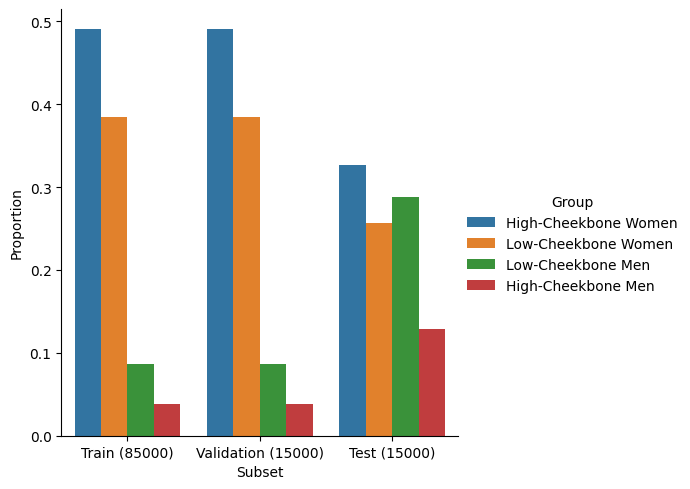

wandb: Currently logged in as: mvujas (mvujas-epfl). Use `wandb login --relogin` to force relogin


Saving best model with accuracy: 0.7239333333333333 (Validation Loss: 0.58849036693573)
Epoch 1: Validation Accuracy: 0.7239333333333333, Validation Loss: 0.58849036693573


Saving best model with accuracy: 0.8202666666666667 (Validation Loss: 0.45925754904747007)
Epoch 2: Validation Accuracy: 0.8202666666666667, Validation Loss: 0.45925754904747007


Saving best model with accuracy: 0.8563333333333333 (Validation Loss: 0.33311134378115337)
Epoch 3: Validation Accuracy: 0.8563333333333333, Validation Loss: 0.33311134378115337


Saving best model with accuracy: 0.8604666666666667 (Validation Loss: 0.3229316174983978)
Epoch 4: Validation Accuracy: 0.8604666666666667, Validation Loss: 0.3229316174983978


Saving best model with accuracy: 0.8666 (Validation Loss: 0.30693673888842266)
Epoch 5: Validation Accuracy: 0.8666, Validation Loss: 0.30693673888842266


Saving best model with accuracy: 0.8686666666666667 (Validation Loss: 0.31065691709518434)
Epoch 6: Validation Accuracy: 0.8686666666666667, Validation Loss: 0.31065691709518434


Epoch 7: Validation Accuracy: 0.8581333333333333, Validation Loss: 0.32576019167900083


Epoch 8: Validation Accuracy: 0.8603333333333333, Validation Loss: 0.3147507905960083


Training Loss,▂█▃▃▃▃▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▆▇███▇█
Validation Loss,█▅▂▁▁▁▁▁
Training Loss,0.27087
Validation Accuracy,0.86033
Validation Loss,0.31475


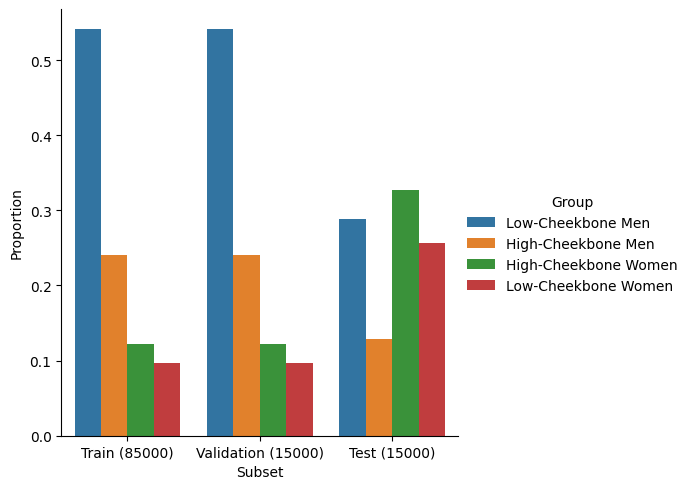

Saving best model with accuracy: 0.8456 (Validation Loss: 0.3599072237809499)
Epoch 1: Validation Accuracy: 0.8456, Validation Loss: 0.3599072237809499


Saving best model with accuracy: 0.8465333333333334 (Validation Loss: 1.0278068383534749)
Epoch 2: Validation Accuracy: 0.8465333333333334, Validation Loss: 1.0278068383534749


Saving best model with accuracy: 0.8684666666666667 (Validation Loss: 0.30656418402989705)
Epoch 3: Validation Accuracy: 0.8684666666666667, Validation Loss: 0.30656418402989705


Epoch 4: Validation Accuracy: 0.8473333333333334, Validation Loss: 0.3611963133017222


Saving best model with accuracy: 0.8732666666666666 (Validation Loss: 0.3429248054822286)
Epoch 5: Validation Accuracy: 0.8732666666666666, Validation Loss: 0.3429248054822286


Epoch 6: Validation Accuracy: 0.8672666666666666, Validation Loss: 0.3164401868979136


Epoch 7: Validation Accuracy: 0.8706666666666667, Validation Loss: 0.31223180492719016


Epoch 8: Validation Accuracy: 0.8587333333333333, Validation Loss: 0.32466946442921957


wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 

In [36]:
celeba_sensitive_col = "Male"
celeba_outcome_col = "High_Cheekbones"

def strata_proportions(df):
    series = df["strata_id"].value_counts(normalize=True)
    strata_id_to_group = {
        0: "Low-Cheekbone Women",
        1: "Low-Cheekbone Men",
        2: "High-Cheekbone Women",
        3: "High-Cheekbone Men",
        
    }
    series.index = series.index.map(strata_id_to_group)
    return series

sensitive_col_val_names = {
    0: "Female",
    1: "Male"
}
def keep_ratios_to_str(keep_ratios):
    return "-".join([
        f"{sensitive_col_val_names[i]}_frac={proportion}"
        for i, proportion in keep_ratios.items()
    ])



train_size = 85000
test_size = 15000
val_size = 15000
# keep_ratios = {
#     0: 1,
#     1: 1,
# }

gender_counts = full_celeba_df["Male"].value_counts()

epochs = 8

device = optimal_device()
image_pre_transform = make_resnet18_transform()

for keep_ratios in [
    {0: 1, 1: 1},
    {0: 1, 1: 0.2},
    {0: 0.2, 1: 1},
    {0: 0.5, 1: 1},
]:
    if sum([
        gender_counts[gid] * ratio
        for gid, ratio in keep_ratios.items()
    ]) < val_size + train_size + 5000:
        print("Skipping", keep_ratios, "due to insufficient data")
        continue
    
    celeba_strata_idx = 2 * full_celeba_df[celeba_outcome_col] + full_celeba_df[celeba_sensitive_col]
    full_celeba_df["strata_id"] = celeba_strata_idx

    celeba_nontest_df, celeba_test_df = sklearn.model_selection.train_test_split(
        full_celeba_df, test_size=test_size, stratify=full_celeba_df["strata_id"], random_state=42
    )

    celeba_trainval_df = reduce_sensitive_entry_ratio(
        celeba_nontest_df, 
        celeba_sensitive_col, 
        celeba_outcome_col, 
        keep_ratios, 
        random_state=42)

    celeba_train_df, celeba_val_df = sklearn.model_selection.train_test_split(
        celeba_trainval_df, test_size=val_size, train_size=train_size, stratify=celeba_trainval_df["strata_id"], random_state=42
    )

    model_name_extension = keep_ratios_to_str(keep_ratios)


    celeba_subset_dfs = {
        "Train": celeba_train_df,
        "Validation": celeba_val_df,
        "Test": celeba_test_df
    }

    proportions_df_list = []
    for subset_name, df in celeba_subset_dfs.items():
        proportions = strata_proportions(df)
        
        proportions = proportions.to_frame().reset_index().rename(columns={"strata_id": "Group", "proportion": "Proportion"})
        proportions["Subset"] = f"{subset_name} ({len(df)})"
        
        proportions_df_list.append(proportions)
    proportions_df = pd.concat(proportions_df_list)
    sns.catplot(data=proportions_df, x="Subset", y="Proportion", hue="Group", kind="bar")
    plt.show()

        
    celeba_nontest_df, celeba_test_df = sklearn.model_selection.train_test_split(
        full_celeba_df, test_size=test_size, stratify=full_celeba_df["strata_id"], random_state=42
    )
    celeba_train_df, celeba_val_df = sklearn.model_selection.train_test_split(
        celeba_nontest_df, test_size=val_size, train_size=train_size, stratify=celeba_nontest_df["strata_id"], random_state=42
    )
        
    config = {
        "outcome_col": celeba_outcome_col,
        "epochs": epochs,
        "num_classes": len(full_celeba_df[celeba_outcome_col].unique()),
        "outcome_col": celeba_outcome_col,
        "save_point": "best"
    }

    model = full_training_loop(celeba_train_df, celeba_val_df, 
                        config=config, 
                        save_path_name_func=lambda config:
        f"../data/models/celeba_resnet18-outcomecol={config['outcome_col']}-{model_name_extension}.pth")
    

In [37]:
wandb.finish()

In [38]:
eval_equalized_odds(model, torch.utils.data.DataLoader(
        CelebAImageDataset(celeba_test_df, 
                            IMAGE_DIR, 
                            celeba_outcome_col,
                            additional_attributes_to_provide=celeba_sensitive_col,
                            transform=image_pre_transform,
                            enable_caching=True),
        batch_size=1000, shuffle=True), device)

KeyboardInterrupt: 

In [53]:
full_training_loop(celeba_train_df, celeba_val_df, config={"freeze_embeddings": False, "epochs": 20}, save_path_name_func=lambda config:
                     f"../data/models/celeba_resnet18-freezing={config['freeze_embeddings']}-outcomecol={config['outcome_col']}-{model_name_extension}.pth")

Epoch 1: Validation Accuracy: 0.9272666666666667, Validation Loss: 0.1737816055615743


Epoch 2: Validation Accuracy: 0.9232, Validation Loss: 0.17830028235912324


Epoch 3: Validation Accuracy: 0.9302, Validation Loss: 0.17768910030523935


Epoch 4: Validation Accuracy: 0.9376666666666666, Validation Loss: 0.14938013553619384


Epoch 5: Validation Accuracy: 0.9376666666666666, Validation Loss: 0.15159135858217876


Epoch 6: Validation Accuracy: 0.9332, Validation Loss: 0.15380999743938445


Epoch 7: Validation Accuracy: 0.9374666666666667, Validation Loss: 0.1550538569688797


Epoch 8: Validation Accuracy: 0.9378666666666666, Validation Loss: 0.1521691044171651


Epoch 9: Validation Accuracy: 0.9352666666666667, Validation Loss: 0.16529347399870556


Epoch 10: Validation Accuracy: 0.9263333333333333, Validation Loss: 0.21296558678150176


Epoch 11: Validation Accuracy: 0.9268, Validation Loss: 0.20774577657381693


Epoch 12: Validation Accuracy: 0.9162, Validation Loss: 0.2734599788983663


Epoch 13: Validation Accuracy: 0.92, Validation Loss: 0.28544527292251587


Epoch 14: Validation Accuracy: 0.9227333333333333, Validation Loss: 0.2231117457151413


Epoch 15: Validation Accuracy: 0.9156666666666666, Validation Loss: 0.36252281864484154


Epoch 16: Validation Accuracy: 0.9215333333333333, Validation Loss: 0.33723854621251426


Epoch 17: Validation Accuracy: 0.9353333333333333, Validation Loss: 0.24916060666243237


Epoch 18: Validation Accuracy: 0.9306, Validation Loss: 0.3457535703976949


Epoch 19: Validation Accuracy: 0.9350666666666667, Validation Loss: 0.3255565126736959


Epoch 20: Validation Accuracy: 0.9120666666666667, Validation Loss: 0.5332569857438405


Training Loss,█▅▅▅▅▄▄▅▅▅▄▅▄▄▅▄▃▄▄▃▂▂▃▃▂▃▁▂▁▁▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▅▄▆██▇██▇▅▅▂▃▄▂▄▇▆▇▁
Validation Loss,▁▂▂▁▁▁▁▁▁▂▂▃▃▂▅▄▃▅▄█
Training Loss,0.01315
Validation Accuracy,0.91207
Validation Loss,0.53326


### Analyzing the resulting model

In [39]:
from sklearn.metrics import roc_curve, auc

In [47]:
def plot_many_roc_curves(roc_metric_dict):
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    for key, roc_metrics in roc_metric_dict.items():
        fprs, tprs = roc_metrics
        plt.plot(fprs, tprs, label=key)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.ylim(0, 1.05)
    plt.xlim(-0.05, 1)
    plt.show()

def analyze_fairness(model, test_df):
    IMAGE_DIR = os.path.join(celeba_path, "img_align_celeba", "img_align_celeba")
    test_loader = torch.utils.data.DataLoader(
        CelebAImageDataset(test_df, 
                            IMAGE_DIR, 
                            "High_Cheekbones",
                            additional_attributes_to_provide=celeba_sensitive_col,
                            transform=make_resnet18_transform(),
                            enable_caching=True),
        batch_size=1000)
    # Collecting predictions
    test_predictions = {
        "true": [],
        "predicted": [],
        "predict_proba": [],
        "sensitive": []
    }
    device = optimal_device()
    model.to(device)
    model.eval()
    with torch.no_grad():
        for x, y, sensitive_feature in tqdm(test_loader, desc="Collecting predictions"):
            x = x.to(device)
            y = y.to(device)
            proba = model(x).softmax(dim=1)
            pred = proba.argmax(dim=1)
            test_predictions["true"].append(y.cpu().numpy())
            test_predictions["predicted"].append(pred.cpu().numpy())
            test_predictions["predict_proba"].append(proba.cpu().numpy()[:, 1])
            test_predictions["sensitive"].append(sensitive_feature.numpy())
    for key in test_predictions:
        test_predictions[key] = np.concatenate(test_predictions[key])
    # Basic metrics
    roc_metrics_dict = {}
    print("General metrics:")
    fpr_tpr = roc_curve(test_predictions["true"], test_predictions["predict_proba"])[:2]
    auc_score = auc(*fpr_tpr)
    roc_metrics_dict[f"Total (AUC: {auc_score:.4})"] = fpr_tpr
    print("\tTest Accuracy: {:.2%} (AUC: {:.4})".format(
        (test_predictions["true"] == test_predictions["predicted"]).mean(),
        auc_score))
    
    for sensitive_val in np.unique(test_predictions["sensitive"]):
        sensitive_col_name = ["Female", "Male"][sensitive_val]
        senstitivity_mask = test_predictions["sensitive"] == sensitive_val
        
        senstiive_col_predictions = {
            key: test_predictions[key][senstitivity_mask]
            for key in test_predictions
        }
        fpr_tpr = roc_curve(senstiive_col_predictions["true"], senstiive_col_predictions["predict_proba"])[:2]
        auc_score = auc(*fpr_tpr)
        roc_metrics_dict[f"{sensitive_col_name} (AUC: {auc_score:.4})"] = fpr_tpr
        print("\tTest Accuracy on {}: {:.2%} (AUC: {:.4})".format(
            sensitive_col_name, 
            (senstiive_col_predictions["true"] == senstiive_col_predictions["predicted"]).mean(),
            auc_score))
    plot_many_roc_curves(roc_metrics_dict)
    print(80*"=")
    # Prediction probabilities
    print("Prediction probabilities:")
    outcome_val = 1
    outcome_name = ["Low Cheeckbone", "High Cheeckbone"][outcome_val]
    print("\tP({}) = {:.2%}".format(outcome_name, (test_predictions["true"] == outcome_val).mean()))
    print("\tP_model({}) = {:.2%}".format(outcome_name, (test_predictions["predicted"] == outcome_val).mean()))

    print()

    for sensitive_val in np.unique(test_predictions["sensitive"]):
        sensitive_col_name = ["Woman", "Man"][sensitive_val]
        senstitivity_mask = test_predictions["sensitive"] == sensitive_val
        
        senstiive_col_predictions = {
            key: test_predictions[key][senstitivity_mask]
            for key in test_predictions
        }
        gt_prob = (senstiive_col_predictions["true"] == outcome_val).mean()
        pred_prob = (senstiive_col_predictions["predicted"] == outcome_val).mean()
        print()
        print("\tP({} | {}) = {:.2%}".format(outcome_name, sensitive_col_name, gt_prob))
        print("\tP_model({} | {}) = {:.2%}".format(outcome_name, sensitive_col_name, pred_prob))
        print("\tDifference: {:.2%}".format(gt_prob - pred_prob))
        
def load_pretrained_resnet18(path, num_classes):
    model = make_resnet18(num_classes)[0]
    model.load_state_dict(
        torch.load(path, weights_only=True))
    return model

Statistics on normal ResNet-18 with no freezing:



General metrics:
	Test Accuracy: 94.18% (AUC: 0.9759)
	Test Accuracy on Female: 91.44% (AUC: 0.9711)
	Test Accuracy on Male: 98.02% (AUC: 0.9459)


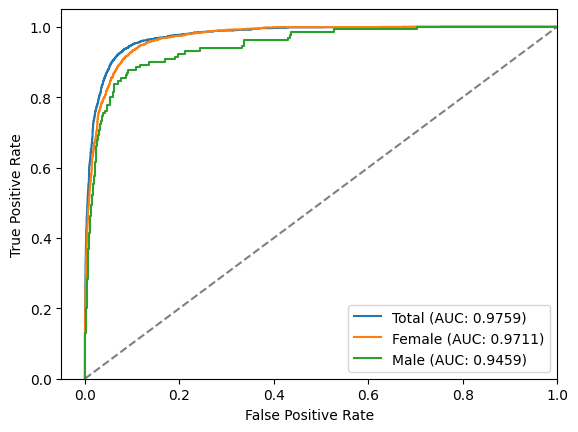

Prediction probabilities:
	P(Blond Hair) = 14.80%
	P_model(Blond Hair) = 11.77%


	P(Blond Hair | Woman) = 23.89%
	P_model(Blond Hair | Woman) = 19.33%
	Difference: 4.56%

	P(Blond Hair | Man) = 2.08%
	P_model(Blond Hair | Man) = 1.18%
	Difference: 0.90%


In [45]:
print("Statistics on normal ResNet-18 with no freezing:\n")
test_model = load_pretrained_resnet18(
    "../data/models/celeba_resnet18-freezing=False-outcomecol=Blond_Hair-Female_frac=1-Male_frac=1.pth", 2)
analyze_fairness(test_model, celeba_test_df)

Statistics on normal ResNet-18 with no freezing using only 20% original women for training:



General metrics:
	Test Accuracy: 94.82% (AUC: 0.9788)
	Test Accuracy on Female: 92.39% (AUC: 0.9726)
	Test Accuracy on Male: 98.22% (AUC: 0.9527)


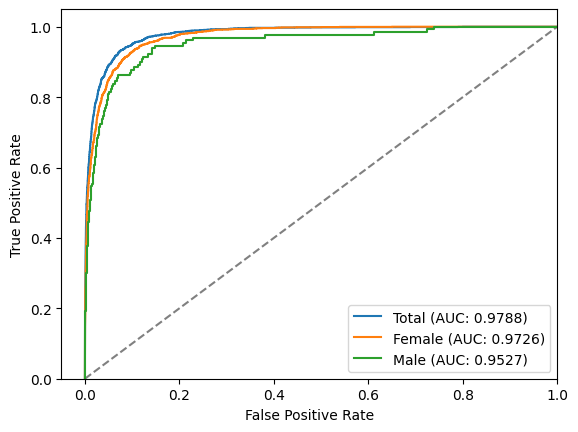

Prediction probabilities:
	P(Blond Hair) = 14.80%
	P_model(Blond Hair) = 13.86%


	P(Blond Hair | Woman) = 23.89%
	P_model(Blond Hair | Woman) = 22.89%
	Difference: 1.01%

	P(Blond Hair | Man) = 2.08%
	P_model(Blond Hair | Man) = 1.23%
	Difference: 0.85%


In [48]:
print("Statistics on normal ResNet-18 with no freezing using only 20% original women for training:\n")
test_model = load_pretrained_resnet18(
    "../data/models/celeba_resnet18-freezing=False-outcomecol=Blond_Hair-Female_frac=0.2-Male_frac=1.pth", 2)
analyze_fairness(test_model, celeba_test_df)

Statistics on normal ResNet-18 with no freezing using only 20% original women for training:



General metrics:
	Test Accuracy: 93.95% (AUC: 0.9766)
	Test Accuracy on Female: 90.88% (AUC: 0.9731)
	Test Accuracy on Male: 98.26% (AUC: 0.926)


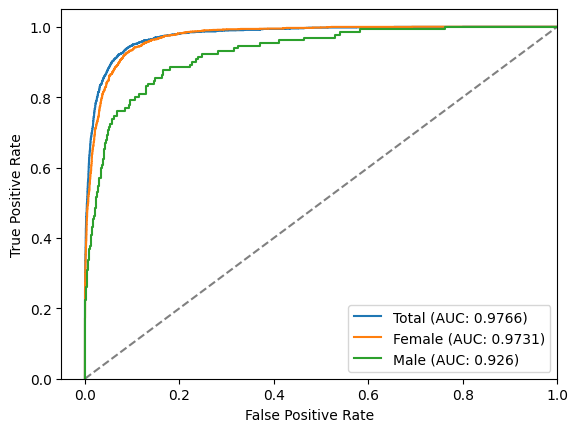

Prediction probabilities:
	P(Blond Hair) = 14.80%
	P_model(Blond Hair) = 10.63%


	P(Blond Hair | Woman) = 23.89%
	P_model(Blond Hair | Woman) = 17.79%
	Difference: 6.10%

	P(Blond Hair | Man) = 2.08%
	P_model(Blond Hair | Man) = 0.62%
	Difference: 1.46%


In [54]:
print("Statistics on normal ResNet-18 with no freezing using only 20% original women for training:\n")
test_model = load_pretrained_resnet18(
    "../data/models/celeba_resnet18-freezing=False-outcomecol=Blond_Hair-Female_frac=1-Male_frac=0.1.pth", 2)
analyze_fairness(test_model, celeba_test_df)

### High Cheekbones evaluation

High Cheeckbones full:



General metrics:
	Test Accuracy: 84.31% (AUC: 0.9226)
	Test Accuracy on Female: 86.54% (AUC: 0.9373)
	Test Accuracy on Male: 81.19% (AUC: 0.8865)


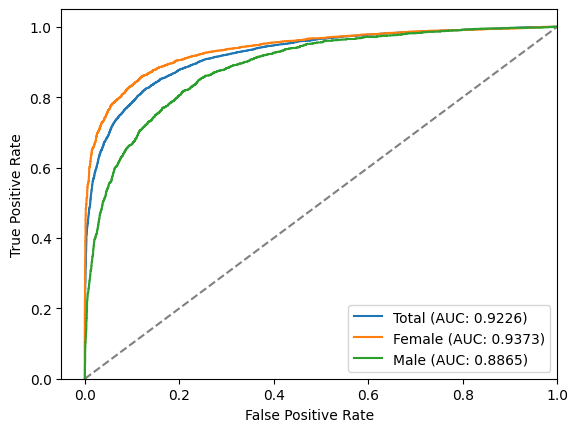

Prediction probabilities:
	P(High Cheeckbone) = 45.50%
	P_model(High Cheeckbone) = 47.93%


	P(High Cheeckbone | Woman) = 56.03%
	P_model(High Cheeckbone | Woman) = 56.74%
	Difference: -0.71%

	P(High Cheeckbone | Man) = 30.76%
	P_model(High Cheeckbone | Man) = 35.59%
	Difference: -4.83%


In [48]:
print("High Cheeckbones full:\n")
test_model = load_pretrained_resnet18(
    "../data/models/celeba_resnet18-outcomecol=High_Cheekbones-Female_frac=1-Male_frac=1.pth", 2)
analyze_fairness(test_model, celeba_test_df)

High Cheeckbones 20% women:



General metrics:
	Test Accuracy: 87.61% (AUC: 0.9476)
	Test Accuracy on Female: 89.03% (AUC: 0.9591)
	Test Accuracy on Male: 85.62% (AUC: 0.9181)


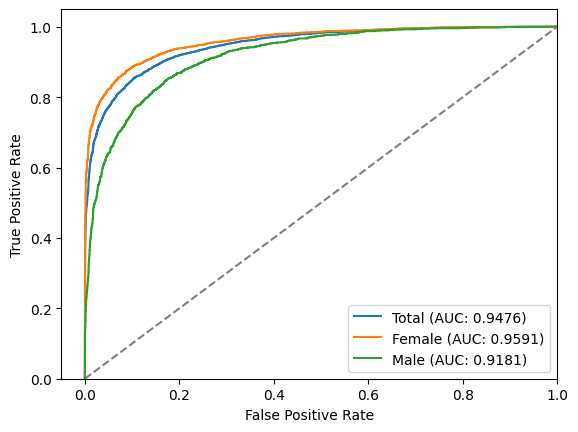

Prediction probabilities:
	P(High Cheeckbone) = 45.50%
	P_model(High Cheeckbone) = 43.00%


	P(High Cheeckbone | Woman) = 56.03%
	P_model(High Cheeckbone | Woman) = 53.15%
	Difference: 2.88%

	P(High Cheeckbone | Man) = 30.76%
	P_model(High Cheeckbone | Man) = 28.80%
	Difference: 1.97%


In [49]:
print("High Cheeckbones 20% women:\n")
test_model = load_pretrained_resnet18(
    "../data/models/celeba_resnet18-outcomecol=High_Cheekbones-Female_frac=0.2-Male_frac=1.pth", 2)
analyze_fairness(test_model, celeba_test_df)

High Cheeckbones 20% men:



General metrics:
	Test Accuracy: 87.21% (AUC: 0.9454)
	Test Accuracy on Female: 88.56% (AUC: 0.9566)
	Test Accuracy on Male: 85.33% (AUC: 0.9145)


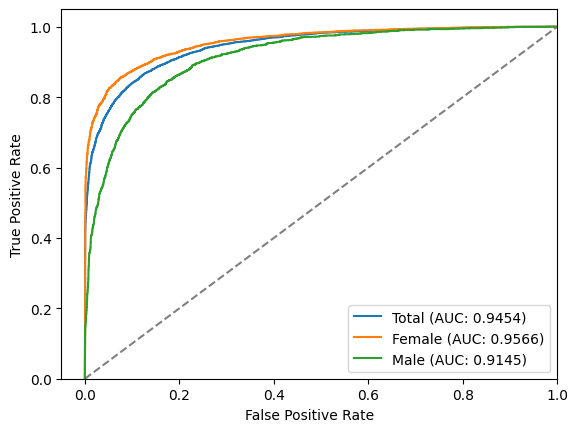

Prediction probabilities:
	P(High Cheeckbone) = 45.50%
	P_model(High Cheeckbone) = 41.70%


	P(High Cheeckbone | Woman) = 56.03%
	P_model(High Cheeckbone | Woman) = 53.16%
	Difference: 2.87%

	P(High Cheeckbone | Man) = 30.76%
	P_model(High Cheeckbone | Man) = 25.66%
	Difference: 5.10%


In [50]:
print("High Cheeckbones 20% men:\n")
test_model = load_pretrained_resnet18(
    "../data/models/celeba_resnet18-outcomecol=High_Cheekbones-Female_frac=1-Male_frac=0.2.pth", 2)
analyze_fairness(test_model, celeba_test_df)